In [ ]:
# TODO:
# Quando un blocco è gia in SINDy eleminalo dai building blocks da considerare
# X A parita di modelli seleziona il modello meno complesso con l'errore piu basso
# Questo procedimento estrae solo un BB alla volta... -> (?) farne di più?

# Fractionary ODE

In [1]:
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import Lasso

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.
from D_CODE.run_simulation import run as run_SRT
from D_CODE.run_simulation_vi import run as run_DCODE

from toolbox.auxiliary_functions import SRT_simulation, D_CODE_simulation, set_param_freq, intercept_library_fun, bb_combinations

# Seed:
np.random.seed(999)

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


### Case $\rho$ fixed
Consider the following fractional system of ODEs: 
$$
\begin{cases}
\dot{x}_0 = \dfrac{x_0^2}{x_1 + \rho} \\[10pt]
\dot{x}_1 = 1
\end{cases}
$$

With $\rho=2$ fixed.

In [2]:
# Select ODE & settings:

ode_name = 'FracODE' # help="name of the ode", type=str
ode_param = '2.' # help="parameters of the ode (default: None)", type=str, default=None
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_sigma = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10
alg = 'tv'

ode_param, freq = set_param_freq(ode_param, freq)

ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 2
dim_k = 0
time_vector = np.arange(0, ode.T + dt, dt)
T = ode.T

(50, 30, 2) (50, 30, 2) (0,)
['X0', 'X1']


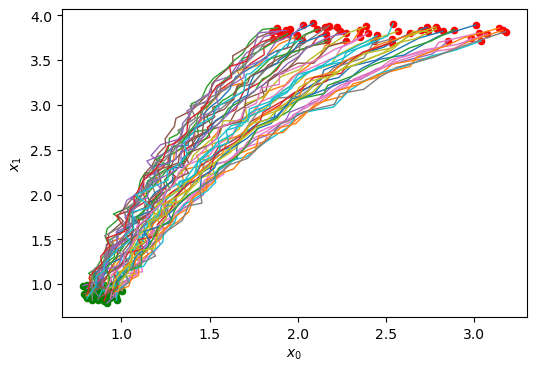

In [3]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_sigma, dim_x, dim_k)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

SINDy_data.plot_configuration(X_list, T)

In [4]:
# additional building blocks -> running SR-T:
building_blocks_lambda0, function_names0 = SRT_simulation(ode_name, ode_param, 0, freq, n_sample, noise_sigma, alg='tv', seed=seed, n_seed=n_seed, T=T)
building_blocks_lambda1, function_names1 = SRT_simulation(ode_name, ode_param, 1, freq, n_sample, noise_sigma, alg='tv', seed=seed, n_seed=n_seed, T=T)

# additional building blocks -> running D-CODE:
# building_blocks_lambda0, function_names0 = D_CODE_simulation(ode_name, ode_param, 0, freq, n_sample, noise_sigma, seed=seed, n_seed=n_seed, T=T)
# building_blocks_lambda1, function_names1 = D_CODE_simulation(ode_name, ode_param, 1, freq, n_sample, noise_sigma, seed=seed, n_seed=n_seed, T=T)

Running with: ode_name=FracODE, ode_param=[2.0], x_id=0, freq=10, n_sample=50, noise_sigma=0.01, alg=tv, seed=100, n_seed=1
Dataset shape:  (31, 50, 2)
Functions set:  {'sub': 1, 'mul': 1, 'add': 1, 'neg': 1, 'sin': 1, 'pow': 1, 'log': 1, 'div': 1}
 


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)



SR-T model:  X0**C/(C + X1)

building blocks:
X0**2
1/(X1 + 1.9972309850338754)
 
number of building blocks:  2
 
Running with: ode_name=FracODE, ode_param=[2.0], x_id=1, freq=10, n_sample=50, noise_sigma=0.01, alg=tv, seed=100, n_seed=1
Dataset shape:  (31, 50, 2)
Functions set:  {'sub': 1, 'mul': 1, 'add': 1, 'neg': 1, 'sin': 1, 'pow': 1, 'log': 1, 'div': 1}
 

SR-T model:  C

building blocks:
 
number of building blocks:  0
 


Con il parametro di default sia D-CODE che SR-T sono in grado di identificare il building block 1/(X1 + 1), necessario affinche poi con SINDy si possa determinare la dinamica. Nota che entrambi trovano la soluzione corretta.
Anche cambiando il parametro $\rho$ i building blocks trovati sono quelli giusti!

In [8]:
# combine the two blocks:
bbs, fns = bb_combinations(building_blocks_lambda0, building_blocks_lambda1, function_names0, function_names1, ode.init_high, ode.init_low, dim_x, dim_k)

intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

errors = []
n_features_vec = []
for i in range(len(bbs)):

    # building block library:
    custom_library = ps.CustomLibrary(library_functions=bbs[i], function_names=fns[i])

    # enlarged library, adding the building block to polynomial library:
    generalized_library = ps.GeneralizedLibrary(
        libraries=[polynomial_library, custom_library],
        tensor_array=[[1, 1]] 
    )

    # add the intercept:
    final_library = ps.ConcatLibrary([intercept_library, generalized_library])

    # fitting the model:
    model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.2))
    model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)

    # library:
    # print('')
    # print('library:')
    # library_terms = final_library.get_feature_names(input_features=feature_names)
    # for term in library_terms:
    #     print(term)

    # final model:
    print('')
    print('model:')
    model.print()

    # evaluate the model:
    
    # filter too complex models (for sure not correct and likely to crash the code):
    coefficients = model.coefficients()
    lasso_penalty = np.sum(np.abs(coefficients))
    if np.count_nonzero(np.array(model.coefficients())) < 10 and lasso_penalty < 10:

        # compute MSE:
        _, mse = SINDy_data.evaluate_RMSE(model, ode, freq, 10, ode.init_high, ode.init_low, dim_k)

        # lasso penalty:
        alpha = 0.01 # regularization parameter
        coefficients = model.coefficients()
        lasso_penalty = np.sum(np.abs(coefficients))

        # final evaluation metric:
        error = mse + alpha * lasso_penalty
        print('')
        print('error:', error)
    else:
        error = 1000
        print('')
        print('Too complex model')
    
    errors.append(error)
    n_features_vec.append(np.count_nonzero(np.array(model.coefficients())))
    print('')
    

print('errors:', errors)


model:
(X0)' = 0.366 X0
(X1)' = 0.998 1

error: 0.024922660775043994


model:
(X0)' = 0.991 X0^2 1/(X1 + 1.9972309850338754)
(X1)' = 0.998 1

error: 0.01999643993524796

errors: [0.024922660775043994, 0.01999643993524796]


In [ ]:
# NOTE: Dovuto aumentare la penalità di lambda da 0.1 a 0.2
# NOTE: Nel building block gia c'è X0**2 -> (?) gestire questa situazione 

In [12]:
# Final model:
min_error = min(errors)
idxs = [i for i, e in enumerate(errors) if abs(e - min_error) < 0.01]
n_features_vec_2 = [n_features_vec[i] for i in idxs]

if len(idxs) > 1:
    print('Multiple models with similar error, selecting the simplest one with the lowest error')
    print('')
    # trova il numero minimo di feature tra i candidati
    min_features = min(n_features_vec_2)
    # prendi tutti gli indici che hanno quel numero di feature
    idxs_min_feat = [idxs[i] for i, nf in enumerate(n_features_vec_2) if nf == min_features]
    # tra questi, scegli quello con errore minore
    idx = idxs_min_feat[np.argmin([errors[i] for i in idxs_min_feat])]
else:
    idx = idxs[0]


# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

# custom library with building blocks:
custom_library = ps.CustomLibrary(library_functions=bbs[idx], function_names=fns[idx])
model = ps.SINDy(feature_names=feature_names, feature_library=custom_library, optimizer=ps.STLSQ(threshold=0.01))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)
building_block = custom_library.get_feature_names(input_features=feature_names)

# enlarged library, adding building blocks to polynomial library:
generalized_library = ps.GeneralizedLibrary(
    libraries=[polynomial_library, custom_library],
    tensor_array=[[1, 1]] 
)

# add the intercept:
final_library = ps.ConcatLibrary([intercept_library, generalized_library])

# fitting the model:
model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.2))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)

# library:
print('')
length = 0
#print('library:')
library_terms = final_library.get_feature_names(input_features=feature_names)
for term in library_terms:
    print(term)
    length += 1
print('length:', length)
print('')


# best builging block:
print('Best building block:')
print(building_block)
print('')

# final model:
print('Simbolic-SINDy model:')
model.print()

Multiple models with similar error, selecting the simplest one with the lowest error


1
X0
X1
X0^2
X0 X1
X1^2
1/(X1 + 1.9972309850338754)
X0 1/(X1 + 1.9972309850338754)
X1 1/(X1 + 1.9972309850338754)
X0^2 1/(X1 + 1.9972309850338754)
X0 X1 1/(X1 + 1.9972309850338754)
X1^2 1/(X1 + 1.9972309850338754)
length: 12

Best building block:
['1/(X1 + 1.9972309850338754)']

Simbolic-SINDy model:
(X0)' = 0.991 X0^2 1/(X1 + 1.9972309850338754)
(X1)' = 0.998 1


Best Model RMSE:  0.007249404856221211


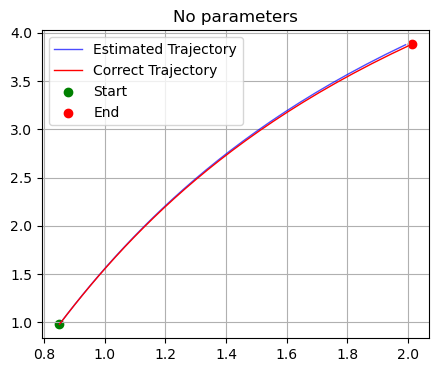

In [ ]:
# evaluation
n_sample = 25
rmse_sigma, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, ode.init_high, ode.init_low, dim_k)
print('Best Model RMSE: ', rmse_sigma)

n_sample = 1
title = r'No parameters'
SINDy_data.evaluate_traj(model, ode, freq, n_sample, [0.85, 0.98], [0.85, 0.98], dim_x, dim_k, title=title, T_aux=3)

### Case $\rho$ varying
Consider the following fractional system of ODEs: 
$$
\begin{cases}
\dot{x}_0 = \dfrac{x_0^2}{x_1 + \rho} \\[10pt]
\dot{x}_1 = 1
\end{cases}
$$

With $\rho\in[1,2]$ varying.

In [2]:
# Select ODE & settings:

ode_name = 'FracODE_par_rho' # help="name of the ode", type=str
ode_param = None # help="parameters of the ode (default: None)", type=str, default=None
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_sigma = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10
alg = 'tv'

ode_param, freq = set_param_freq(ode_param, freq)

ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 2
dim_k = 1
time_vector = np.arange(0, ode.T + dt, dt)
T = ode.T

(50, 30, 2) (50, 30, 2) (50, 30)
['X0', 'X1', 'X2']


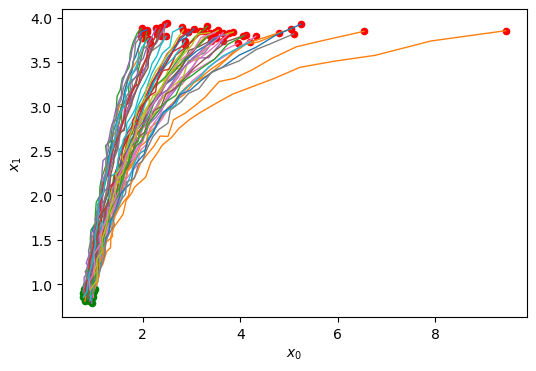

In [3]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_sigma, dim_x, dim_k)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

SINDy_data.plot_configuration(X_list, T)

In [4]:
# additional building blocks -> running SR-T:
building_blocks_lambda0, function_names0 = SRT_simulation(ode_name, ode_param, 0, freq, n_sample, noise_sigma, alg='tv', seed=seed, n_seed=n_seed, T=T)
building_blocks_lambda1, function_names1 = SRT_simulation(ode_name, ode_param, 1, freq, n_sample, noise_sigma, alg='tv', seed=seed, n_seed=n_seed, T=T)

# additional building blocks -> running D-CODE:
# building_blocks_lambda0, function_names0 = D_CODE_simulation(ode_name, ode_param, 0, freq, n_sample, noise_sigma, seed=seed, n_seed=n_seed, T=T)
# building_blocks_lambda1, function_names1 = D_CODE_simulation(ode_name, ode_param, 1, freq, n_sample, noise_sigma, seed=seed, n_seed=n_seed, T=T)

Running with: ode_name=FracODE_par_rho, ode_param=None, x_id=0, freq=10, n_sample=50, noise_sigma=0.01, alg=tv, seed=100, n_seed=1
Dataset shape:  (31, 50, 3)
Functions set:  {'sub': 1, 'mul': 1, 'add': 1, 'neg': 1, 'sin': 1, 'pow': 1, 'log': 1, 'div': 1}
 


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)



SR-T model:  X0**C/(X1 + X2)

building blocks:
X0**1.9972309850338754
X2**1.68304689752157
log(2*X0)
sin(log(2*X0))
X0**1.5351573351239596
X0**1.1194891647291247
1.1067078130959844/X2
X0**1.388244564289013
1.8935132807694917*X0**(-1.388244564289013)
X0/(sin(X0) + 1.8571125865876965)
0.62791479896266684*X0/X2
1/(X1 + X2)
 
number of building blocks:  12
 
Running with: ode_name=FracODE_par_rho, ode_param=None, x_id=1, freq=10, n_sample=50, noise_sigma=0.01, alg=tv, seed=100, n_seed=1
Dataset shape:  (31, 50, 3)
Functions set:  {'sub': 1, 'mul': 1, 'add': 1, 'neg': 1, 'sin': 1, 'pow': 1, 'log': 1, 'div': 1}
 

SR-T model:  C

building blocks:
 
number of building blocks:  0
 


In [10]:
# combine the two blocks:
bbs, fns = bb_combinations(building_blocks_lambda0, building_blocks_lambda1, function_names0, function_names1, ode.init_high, ode.init_low, dim_x, dim_k)

intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

errors = []
n_features_vec = []
for i in range(len(bbs)):

    # building block library:
    custom_library = ps.CustomLibrary(library_functions=bbs[i], function_names=fns[i])

    # enlarged library, adding the building block to polynomial library:
    generalized_library = ps.GeneralizedLibrary(
        libraries=[polynomial_library, custom_library],
        tensor_array=[[1, 1]] 
    )

    # add the intercept:
    final_library = ps.ConcatLibrary([intercept_library, generalized_library])

    # fitting the model:
    model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.35))
    model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)

    # library:
    # print('')
    # print('library:')
    # library_terms = final_library.get_feature_names(input_features=feature_names)
    # for term in library_terms:
    #     print(term)

    # final model:
    print('')
    print('model:')
    model.print()

    # evaluate the model:
    
    # filter too complex models (for sure not correct and likely to crash the code):
    coefficients = model.coefficients()
    lasso_penalty = np.sum(np.abs(coefficients))
    if np.count_nonzero(np.array(model.coefficients())) < 10 and lasso_penalty < 10:

        # compute MSE:
        _, mse = SINDy_data.evaluate_RMSE(model, ode, freq, 10, ode.init_high, ode.init_low, dim_k)

        # lasso penalty:
        alpha = 0.01 # regularization parameter
        coefficients = model.coefficients()
        lasso_penalty = np.sum(np.abs(coefficients))

        # final evaluation metric:
        error = mse + alpha * lasso_penalty
        print('')
        print('error:', error)
    else:
        error = 1000
        print('')
        print('Too complex model')
    
    errors.append(error)
    n_features_vec.append(np.count_nonzero(np.array(model.coefficients())))
    print('')
    

print('errors:', errors)


model:
(X0)' = -14.743 X0^2 + 15.003 X0**1.9972309850338754
(X1)' = 1.003 1

Too complex model


model:
(X0)' = 2.554 X0 + -1.454 X1 + -0.692 X0 X2**1.68304689752157 + 0.467 X1 X2**1.68304689752157
(X1)' = 1.003 1

error: 7.224469997043186


model:
(X0)' = -1.639 X0 + -1.777 X1 + 6.517 X0^2 + 2.429 X0 X1 + -4.738 X0 log(2*X0) + -1.421 X0^2 log(2*X0) + -1.213 X0 X1 log(2*X0)
(X1)' = 1.003 1

Too complex model


model:
(X0)' = 1.127 X1 + 0.899 X0^2 + -2.189 X0 X1 + -0.636 X0 X2 + 2.984 sin(log(2*X0)) + -3.483 X0 sin(log(2*X0)) + 0.498 X0^2 sin(log(2*X0)) + 1.570 X0 X1 sin(log(2*X0)) + 0.562 X0 X2 sin(log(2*X0))
(X1)' = 1.003 1

Too complex model


model:
(X0)' = 0.366 X0**1.5351573351239596
(X1)' = 1.003 1

error: 0.09251388585762371


model:
(X0)' = 0.586 X0
(X1)' = 1.003 1

error: 0.3103104473301849


model:
(X0)' = -0.902 1.1067078130959844/X2 + 1.143 X0 1.1067078130959844/X2
(X1)' = 0.907 X2 1.1067078130959844/X2

error: 0.178122624815381


model:
(X0)' = 0.826 1 + -1.916 X0 + 1.853

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.35) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.35) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.35) and eliminated all coefficients
  warnings.warn(



model:
(X0)' = 1.114 X0/(sin(X0) + 1.8571125865876965)
(X1)' = 1.003 1

error: 0.13434194303465133


model:
(X0)' = -0.680 1 + 0.360 X0 + 1.208 0.62791479896266684*X0/X2
(X1)' = 1.003 1

error: 0.1780172340243027


model:
(X0)' = 0.958 X0^2 1/(X1 + X2)
(X1)' = 1.003 1

error: 0.036893502273931116

errors: [1000, 7.224469997043186, 1000, 1000, 0.09251388585762371, 0.3103104473301849, 0.178122624815381, 0.17298756068751184, 1000, 0.13434194303465133, 0.1780172340243027, 0.036893502273931116]


In [ ]:
# NOTE: anche qui ho dovuto aumentare brutalmente la sparsità: dal classico 0.1 a 0.35!

In [ ]:
# Final model:
min_error = min(errors)
idxs = [i for i, e in enumerate(errors) if abs(e - min_error) < 0.01]
n_features_vec_2 = [n_features_vec[i] for i in idxs]

if len(idxs) > 1:
    print('Multiple models with similar error, selecting the simplest one with the lowest error')
    print('')
    # trova il numero minimo di feature tra i candidati
    min_features = min(n_features_vec_2)
    # prendi tutti gli indici che hanno quel numero di feature
    idxs_min_feat = [idxs[i] for i, nf in enumerate(n_features_vec_2) if nf == min_features]
    # tra questi, scegli quello con errore minore
    idx = idxs_min_feat[np.argmin([errors[i] for i in idxs_min_feat])]
else:
    idx = idxs[0]


# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

# custom library with building blocks:
custom_library = ps.CustomLibrary(library_functions=bbs[idx], function_names=fns[idx])
model = ps.SINDy(feature_names=feature_names, feature_library=custom_library, optimizer=ps.STLSQ(threshold=0.01))
model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
building_block = custom_library.get_feature_names(input_features=feature_names)

# enlarged library, adding building blocks to polynomial library:
generalized_library = ps.GeneralizedLibrary(
    libraries=[polynomial_library, custom_library],
    tensor_array=[[1, 1]] 
)

# add the intercept:
final_library = ps.ConcatLibrary([intercept_library, generalized_library])

# fitting the model:
model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.35))
model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)

# library:
print('')
length = 0
#print('library:')
library_terms = final_library.get_feature_names(input_features=feature_names)
for term in library_terms:
    print(term)
    length += 1
print('length:', length)
print('')


# best builging block:
print('Best building block:')
print(building_block)
print('')

# final model:
print('Symbolic-SINDy model:')
model.print()


1
X0
X1
X2
X0^2
X0 X1
X0 X2
X1^2
X1 X2
X2^2
1/(X1 + X2)
X0 1/(X1 + X2)
X1 1/(X1 + X2)
X2 1/(X1 + X2)
X0^2 1/(X1 + X2)
X0 X1 1/(X1 + X2)
X0 X2 1/(X1 + X2)
X1^2 1/(X1 + X2)
X1 X2 1/(X1 + X2)
X2^2 1/(X1 + X2)
length: 20

Best building block:
['1/(X1 + X2)']

Simbolic-SINDy model:
(X0)' = 0.958 X0^2 1/(X1 + X2)
(X1)' = 1.003 1


Best Model RMSE:  0.06282053239383725


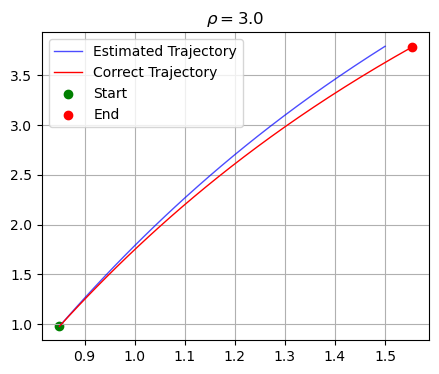

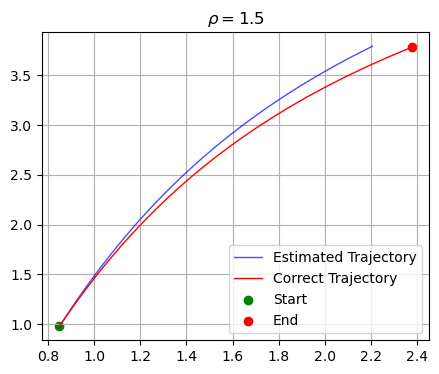

In [15]:
# evaluation
n_sample = 25
rmse_sigma, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, ode.init_high, ode.init_low, dim_k)
print('Best Model RMSE: ', rmse_sigma)

n_sample = 1
title = r'$\rho = 3.0$'
SINDy_data.evaluate_traj(model, ode, freq, n_sample, [0.85, 0.98, 3.0], [0.85, 0.98, 3.0], dim_x, dim_k, title=title, T_aux=3)

n_sample = 1
title = r'$\rho = 1.5$'
SINDy_data.evaluate_traj(model, ode, freq, n_sample, [0.85, 0.98, 1.5], [0.85, 0.98, 1.5], dim_x, dim_k, title=title, T_aux=3)

Commenti finali:

In questo contesto Symbolic-SINDy si rileva molto efficace, anche in caso di rumore e nel caso parametrizzato rispetto a $\rho$.
Sarebbe impensabile inserire a priori quel building block, e grazie alla Symbolic regression questa informazione può essere aggiunta dentro la libreria, e risolvere il problema!

OSSERVAZIONI PRATICHE SU PROBLEMI RELATIVI A SYMBOLIC-SINDy:
- In questo notbook un problema evidenziato è che a volte la Symbolic Regression genera building blocks che sarebbero gia presenti nella libreria di SINDy: sarebbe opportuno eliminare quei blocchi. In generale sarebbe opportuno aggiungere un controllo sui building blocks trovati ed eliminare quelli rindondanti o che generano errori
- Spesso e volentieri il lambda 0.1 non è sufficientemente sparso: ha senso fare il controllo dei modelli per diversi valori di lambda?
- Attenzione alla gestione del modello meno complesso: prima il codice a parità di errori vicini estraeva il modello 'meno complesso'. Ma in realtà estraeva il PRIMO modello meno complesso! -> adesso estrae tra i candidati quelli meno complessi, e sceglie quello a errore piu basso